In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle
import ast
import re

In [15]:
df = pd.read_csv('train.csv')

In [16]:
df.drop(columns=['id', 'homepage', 'imdb_id', 'original_language', 'original_title', 'poster_path', 
                 'tagline', 'overview', 'belongs_to_collection', 'title', 'spoken_languages', 
                 'production_companies', 'production_countries'], inplace=True)

In [17]:
df.isnull().sum()

budget            0
genres            7
popularity        0
release_date      0
runtime           2
status            0
Keywords        276
cast             13
crew             16
revenue           0
dtype: int64

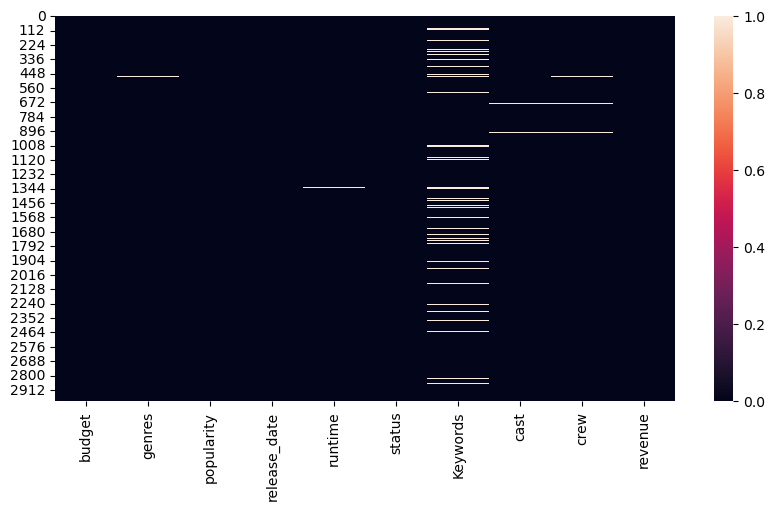

In [18]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull())
plt.show()

In [19]:
cols = ['genres', 'Keywords', 'cast', 'crew']
for col in cols:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [20]:
df['director'] = df['crew'].apply(lambda x: [i['name'] for i in x if isinstance(i, dict) and i['job'] == 'Director'] if isinstance(x, list) else np.nan)
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x[:3] if isinstance(i, dict)] if isinstance(x, list) else np.nan)
df['Keywords'] = df['Keywords'].apply(lambda x: [i['name'] for i in x[:3] if isinstance(i, dict)] if isinstance(x, list) else np.nan)
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x if isinstance(i, dict)] if isinstance(x, list) else np.nan)
df.drop(columns=['crew'], inplace=True)

In [21]:
obj_col = df.select_dtypes('object').columns
for col in obj_col:
    mode_values = df[col].mode()

    # Check if the mode exists and is not empty
    if not mode_values.empty:
        mode_value = mode_values.iloc[0]
        # Handle list/tuple columns
        if isinstance(mode_value, (list, tuple)):
            print(f"Column {col} contains a list/tuple. Converting lists to strings.")
            # Convert list/tuple columns to strings
            df[col] = df[col].apply(lambda x: ', '.join(x) if isinstance(x, (list, tuple)) else x)
            df[col] = df[col].fillna('Unknown')  # Fill NaN with 'Unknown'
        else:
            df[col] = df[col].fillna(mode_value)
    else:
        print(f"No mode found for column: {col}")

Column genres contains a list/tuple. Converting lists to strings.
Column Keywords contains a list/tuple. Converting lists to strings.
Column cast contains a list/tuple. Converting lists to strings.
Column director contains a list/tuple. Converting lists to strings.


In [22]:
df['popularity'] = df['popularity'].astype(float)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

C:\Users\hp\AppData\Local\Temp\ipykernel_3712\550962158.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')


In [23]:
df = df.dropna(subset=['runtime', 'revenue'])

In [24]:
df['popularity'] = df['popularity'].astype(float)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')


In [25]:
df = df.dropna(subset=['runtime', 'revenue'])

In [26]:
df['year'] = df['release_date'].dt.year
df.drop(columns='release_date', inplace=True)

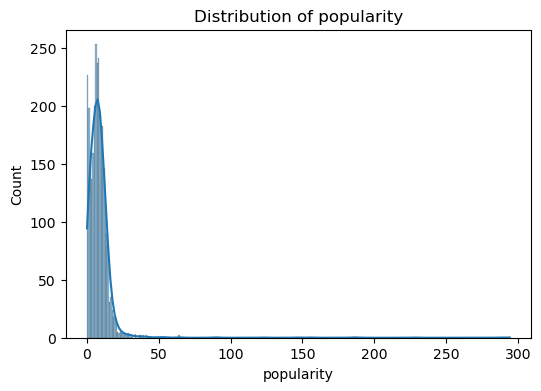

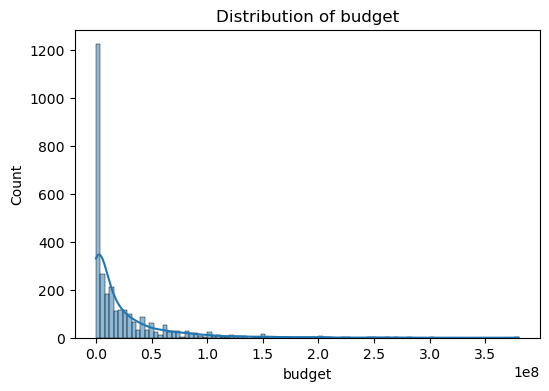

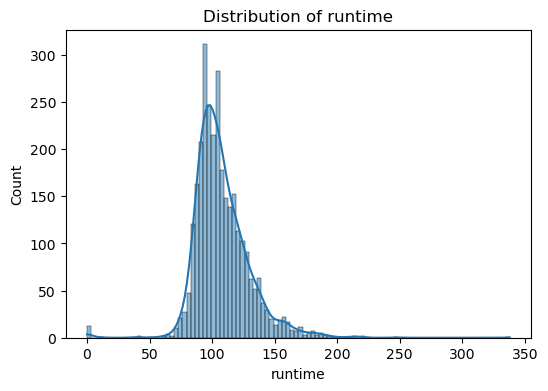

In [27]:
cols = ['popularity','budget','runtime']
for col in cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

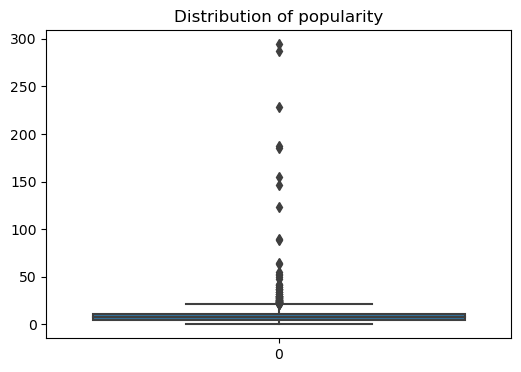

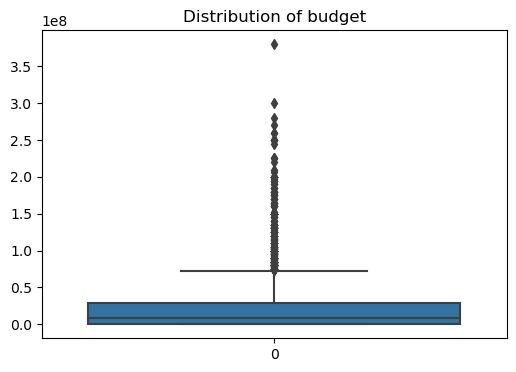

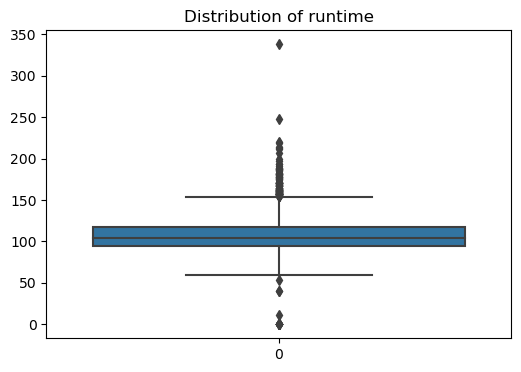

In [28]:
cols = ['popularity','budget','runtime']
for col in cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

Text(0.5, 1.0, 'Budget vs Popularity')

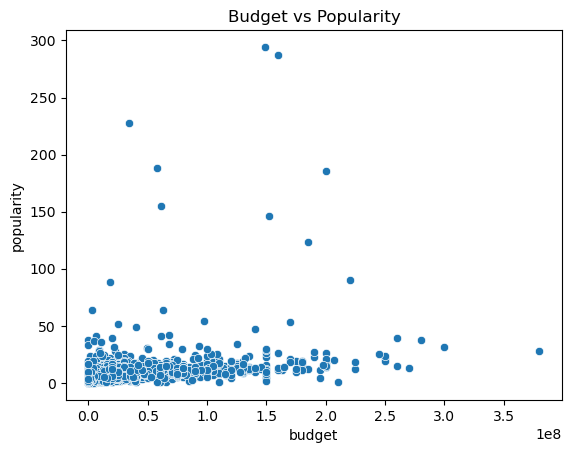

In [29]:
sns.scatterplot(x=df['budget'],y=df['popularity'])
plt.title('Budget vs Popularity')

Text(0.5, 1.0, 'Budget vs Popularity')

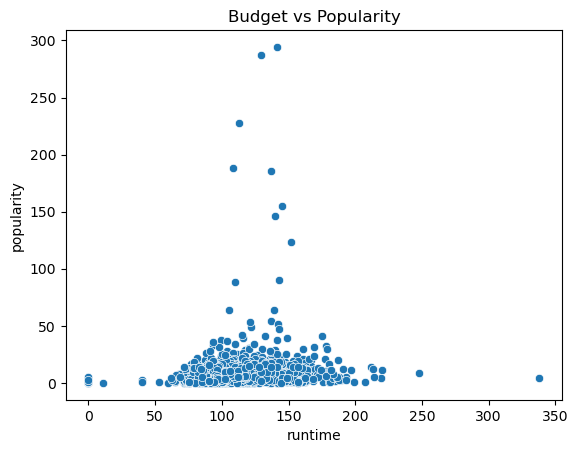

In [30]:
sns.scatterplot(x=df['runtime'],y=df['popularity'])
plt.title('Budget vs Popularity')

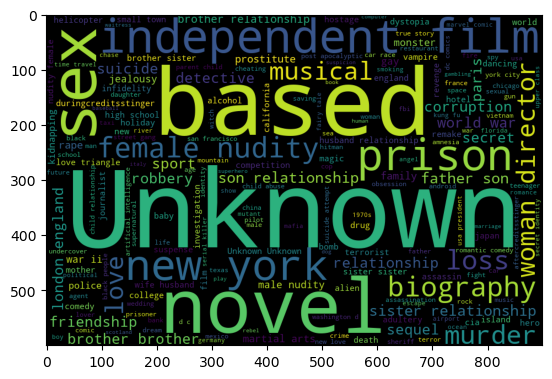

In [31]:
from wordcloud import WordCloud
df['Keywords'] = df['Keywords'].astype(str)
keyword = ' '.join(df['Keywords'])
wc = WordCloud(width=900,height=600).generate(keyword)
plt.imshow(wc)

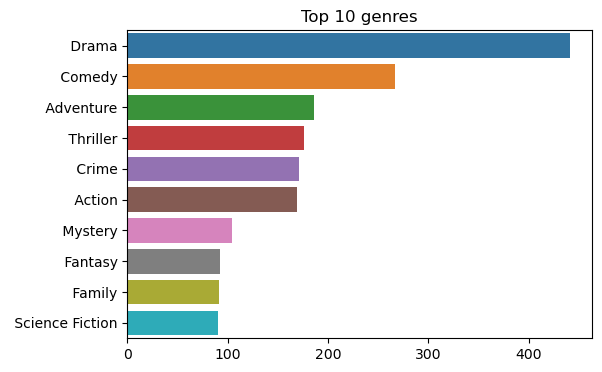

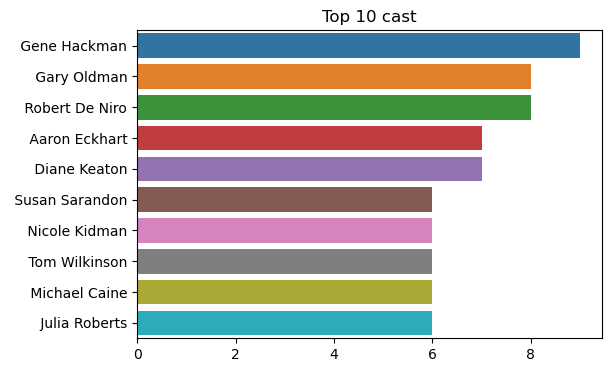

In [32]:
cols = ['genres','cast']
for col in cols:
    plt.figure(figsize=(6,4))
    string = ' '.join(df[col])
    spl =  string.split(',')
    s = pd.Series(spl).value_counts(ascending=False)[:10]
    sns.barplot(x=s.values,y=s.index)
    plt.title(f'Top 10 {col}')
    plt.show()    

Text(0, 0.5, 'movie count')

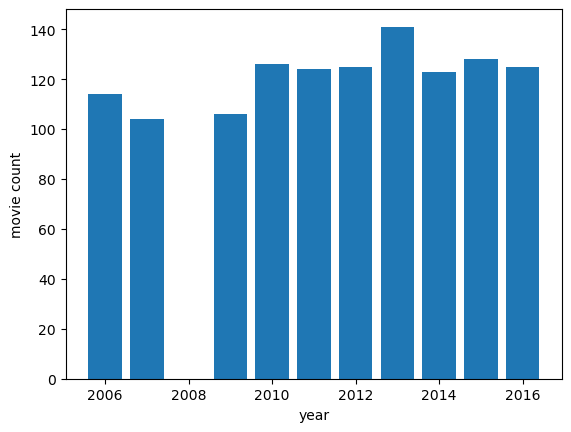

In [33]:
date = df['year'].value_counts()
date = date.iloc[0:10]
plt.bar(x=date.index, height=date.values.flatten())
plt.xlabel('year')
plt.ylabel('movie count')


In [24]:
mlb_genres = MultiLabelBinarizer()
mlb_keywords = MultiLabelBinarizer()
mlb_cast = MultiLabelBinarizer()

In [25]:
df_genres = pd.DataFrame(mlb_genres.fit_transform(df['genres'].apply(lambda x: x if isinstance(x, list) else [])), columns=mlb_genres.classes_, index=df.index)
df_keywords = pd.DataFrame(mlb_keywords.fit_transform(df['Keywords'].apply(lambda x: x if isinstance(x, list) else [])), columns=mlb_keywords.classes_, index=df.index)
df_cast = pd.DataFrame(mlb_cast.fit_transform(df['cast'].apply(lambda x: x if isinstance(x, list) else [])), columns=mlb_cast.classes_, index=df.index)

In [26]:
df = pd.concat([df, df_genres, df_keywords, df_cast], axis=1)

In [27]:
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

In [28]:
scaler = StandardScaler()
df[['budget', 'runtime', 'popularity', 'year']] = scaler.fit_transform(df[['budget', 'runtime', 'popularity', 'year']])

In [29]:
X = df.drop(columns=['revenue', 'genres', 'Keywords', 'cast', 'director'])
y = np.log1p(df['revenue'])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
pred_for_train=xgb_model.predict(X_train)
pred_for_test=xgb_model.predict(X_test)

In [33]:
rmse_for_train=np.sqrt(mean_squared_error(y_train, pred_for_train))
rmse_for_test=np.sqrt(mean_squared_error(y_test,pred_for_test))

print(f"rmse of training :{rmse_for_train}")
print(f"rmse of test :   {rmse_for_test}")

rmse of training :0.7105343147626673
rmse of test :   2.2776971423190333


In [34]:
# Save the models and encoders
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(le, file)
with open('mlb_genres.pkl', 'wb') as file:
    pickle.dump(mlb_genres, file)
with open('mlb_keywords.pkl', 'wb') as file:
    pickle.dump(mlb_keywords, file)
with open('mlb_cast.pkl', 'wb') as file:
    pickle.dump(mlb_cast, file)

In [35]:
def get_user_input():
    user_input = {}
    try:
        user_input['budget'] = float(input("Enter the budget: "))
        user_input['popularity'] = float(input("Enter the popularity: "))
        user_input['runtime'] = float(input("Enter the runtime: "))
        user_input['status'] = input("Enter the status (e.g., 'Released', 'Post Production'): ")
        user_input['year'] = int(input("Enter the release year: "))
        user_input['genres'] = input("Enter genres (comma separated): ").split(',')
        user_input['Keywords'] = input("Enter keywords (comma separated): ").split(',')
        user_input['cast'] = input("Enter cast (comma separated): ").split(',')
    except ValueError as e:
        print(f"Invalid input: {e}")
        return None
    
    return user_input

In [36]:
def preprocess_input(user_input):
    df_input = pd.DataFrame([user_input])

    # Load saved encoders and scaler
    with open('pickle files/scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    with open('pickle files/labelencoder.pkl', 'rb') as file:
        le = pickle.load(file)
    with open('pickle files/mlb_genres.pkl', 'rb') as file:
        mlb_genres = pickle.load(file)
    with open('pickle files/mlb_keywords.pkl', 'rb') as file:
        mlb_keywords = pickle.load(file)
    with open('pickle files/mlb_cast.pkl', 'rb') as file:
        mlb_cast = pickle.load(file)

    # Scale numeric features
    df_input[['budget', 'runtime', 'popularity', 'year']] = scaler.transform(df_input[['budget', 'runtime', 'popularity', 'year']])
    
    # Label encode status
    df_input['status'] = le.transform(df_input['status'].astype('str'))

    # Apply MultiLabelBinarizer to genres, keywords, and cast
    df_genres = pd.DataFrame(mlb_genres.transform([user_input['genres']]), columns=mlb_genres.classes_)
    df_keywords = pd.DataFrame(mlb_keywords.transform([user_input['Keywords']]), columns=mlb_keywords.classes_)
    df_cast = pd.DataFrame(mlb_cast.transform([user_input['cast']]), columns=mlb_cast.classes_)
    
    df_input = pd.concat([df_input, df_genres, df_keywords, df_cast], axis=1)
    
    # Align with model training columns
    required_columns = X_train.columns
    df_input = df_input.reindex(columns=required_columns, fill_value=0)
    
    return df_input

In [39]:
def predict_revenue(user_input):
    with open('pickle files/xgb_model.pkl', 'rb') as file:
        model = pickle.load(file)
    
    processed_input = preprocess_input(user_input)
    predicted_log_revenue = model.predict(processed_input)
    
    # Reverse the log transformation
    predicted_revenue = np.expm1(predicted_log_revenue)[0]
    return predicted_revenue

In [40]:
user_input = get_user_input()
if user_input:
    predicted_revenue = predict_revenue(user_input)
    print(f"Predicted Revenue: ${predicted_revenue:,.2f}")
else:
    print("Invalid input. Please try again.")

Enter the budget: 4000
Enter the popularity: 5
Enter the runtime: 37
Enter the status (e.g., 'Released', 'Post Production'): Released
Enter the release year: 2011
Enter genres (comma separated): Horror
Enter keywords (comma separated): duty
Enter cast (comma separated): brad pitt
Predicted Revenue: $1,092,001.25


C:\Users\Hamza Computer\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['Horror'] will be ignored
  warnings.warn(
C:\Users\Hamza Computer\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['duty'] will be ignored
  warnings.warn(
C:\Users\Hamza Computer\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['brad pitt'] will be ignored
  warnings.warn(
